In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionResNetV2

from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers, Sequential
from keras.layers.normalization import BatchNormalization
from keras.models import Model

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
batch_size = 64

In [4]:
# rescale normalizes the data for the images.
# Data is split into train and validation sets
image_data_gen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip = True,
                                    validation_split=0.2)

train_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              subset='training'
                                             )

val_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TB_Chest_Radiography_Database',
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle = False,
                                              subset='validation'
                                             )

test_it = image_data_gen.flow_from_directory(directory='/content/drive/MyDrive/TestImages for TB',
                                              target_size=(224, 224),
                                              batch_size=batch_size,
                                              shuffle = False,
                                              class_mode='binary',
                                             )

Found 5440 images belonging to 2 classes.
Found 1360 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
dnn201 = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_tensor=None,
    input_shape=(224,224,3),
    weights = 'imagenet'
)

dnn201.trainable= False

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
predictions = Dense(1, activation='sigmoid')

model = Sequential([
    dnn201,
    global_avg_layer,
    
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(512, activation='relu'),
    
  
    BatchNormalization(),
    Dropout(0.5),
    
    predictions
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
batch_normalization_408 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               786944    
_________________________________________________________________
batch_normalization_409 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [7]:
epochs = 10
history = model.fit(train_it,
                       validation_data=val_it,
                       epochs=epochs)


Epoch 1/10
85/85 [==============================] - 1524s 17s/step - loss: 0.4900 - accuracy: 0.8187 - val_loss: 0.6899 - val_accuracy: 0.7199
Epoch 2/10
85/85 [==============================] - 127s 1s/step - loss: 0.2669 - accuracy: 0.8983 - val_loss: 0.2503 - val_accuracy: 0.8956
Epoch 3/10
85/85 [==============================] - 126s 1s/step - loss: 0.2384 - accuracy: 0.9037 - val_loss: 0.2101 - val_accuracy: 0.9162
Epoch 4/10
85/85 [==============================] - 127s 1s/step - loss: 0.2163 - accuracy: 0.9096 - val_loss: 0.1749 - val_accuracy: 0.9346
Epoch 5/10
85/85 [==============================] - 126s 1s/step - loss: 0.1916 - accuracy: 0.9245 - val_loss: 0.1633 - val_accuracy: 0.9346
Epoch 6/10
85/85 [==============================] - 127s 2s/step - loss: 0.1941 - accuracy: 0.9259 - val_loss: 0.1362 - val_accuracy: 0.9493
Epoch 7/10
85/85 [==============================] - 127s 1s/step - loss: 0.1765 - accuracy: 0.9322 - val_loss: 0.1474 - val_accuracy: 0.9397
Epoch 8/10


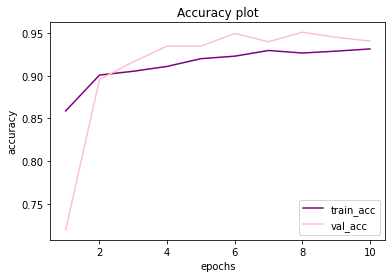

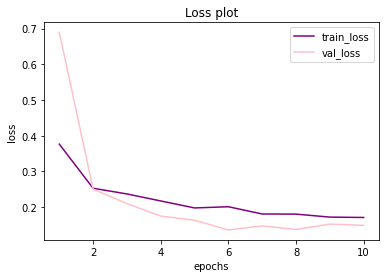

In [8]:
epochs= range(1, len(history.history["accuracy"])+1)

plt.plot(epochs, history.history["accuracy"], color="purple")
plt.plot(epochs, history.history["val_accuracy"], color="pink")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Accuracy plot")
plt.legend(["train_acc", "val_acc"])
plt.show()

plt.plot(epochs, history.history["loss"], color="purple")
plt.plot(epochs, history.history["val_loss"], color="pink")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Loss plot")
plt.legend(["train_loss", "val_loss"])
plt.show()

In [9]:
prediction= model.predict(val_it, verbose=2)
prediction= (prediction > 0.5)
prediction

22/22 - 26s


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [ True]])

In [10]:
val_labels=val_it.classes
val_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [11]:
prediction.shape

(1360, 1)

In [12]:
val_labels.shape

(1360,)

In [13]:
results = model.evaluate(val_it)

22/22 [==============================] - 25s 1s/step - loss: 0.1382 - accuracy: 0.9456


0.9463235294117647
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       680
           1       0.97      0.93      0.95       680

    accuracy                           0.95      1360
   macro avg       0.95      0.95      0.95      1360
weighted avg       0.95      0.95      0.95      1360



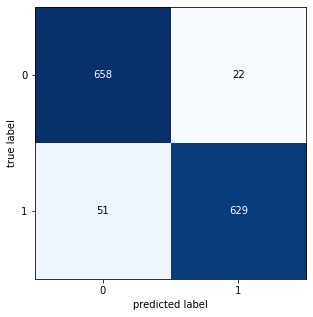

In [14]:
cm = confusion_matrix(val_it.classes, prediction)
plot_confusion_matrix(cm, figsize=(5,5))
print(accuracy_score(val_it.classes, prediction))
print(classification_report(val_it.classes, prediction))

AUC: 0.946


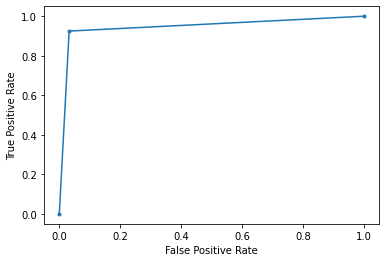

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(val_labels, prediction)
auc = metrics.roc_auc_score(val_labels, prediction)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr,marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Plots for Test Data: 200 images


In [16]:
prediction1 = model.predict(test_it)
prediction1 = (prediction1 > 0.5)
prediction1

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [

In [17]:
test_labels=test_it.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [18]:
prediction1.shape

(200, 1)

In [19]:
test_labels.shape

(200,)

In [20]:
results = model.evaluate(test_it)

4/4 [==============================] - 4s 717ms/step - loss: 0.0938 - accuracy: 0.9700


0.975
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       100
           1       0.97      0.98      0.98       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



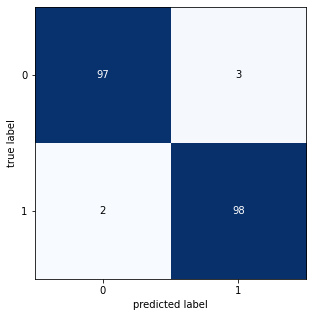

In [21]:
cm1 = confusion_matrix(test_it.classes, prediction1)
plot_confusion_matrix(cm1, figsize=(5,5))
print(accuracy_score(test_it.classes, prediction1))
print(classification_report(test_it.classes, prediction1))

AUC: 0.975


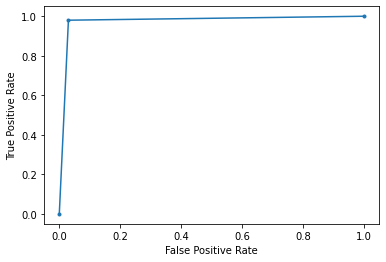

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels, prediction1)
auc = metrics.roc_auc_score(test_labels, prediction1)
print('AUC: %.3f' % auc)
plt.plot(fpr, tpr,marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [23]:
model.save('/content/drive/MyDrive/InceptionResNetV2.h5')